# Dynamics of unique locations sampled by the filament tip 

In [3]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import cmocean
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def_analysis import *
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')

from tqdm import tqdm


# Create a folder for storing Publication figures

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure2'

import _figure_parameters

linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

## Generate a dataframe containing the unique-locations visited time-series data 
from a batch of simulations

In [12]:
# Choose the data folder which we want to plot

data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'

parameter = 'potDipole strength'

parameter_values_to_plot = [0.5,  1.21, 1.59, 1.71, 2.74]
# parameter_values_to_plot = [1.2]

In [13]:
# Interpolate time-series data into a common time array
n_times = 1000

# Data frame containing the ensemble data
df_ensemble = pd.DataFrame({})

# Metadata to save
# metadata_list = ['spring constant', 'kappa_hat','potDipole strength']

count = 1
# Find all simulation data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files
for root, dirs, files in os.walk(data_folder):
       
    
    for file in files:
            
        if('unique_counts_timeseries' in file): # find all the unique count time-series data
            
            analysis_file = file.replace('unique_counts_timeseries', 'analysis')
            
            analysis_folder, *rest = os.path.split(root)

            analysis_file_path = os.path.join(analysis_folder,analysis_file)
            
            print(analysis_file_path)
            assert(os.path.exists(analysis_file_path))
            
            # Load the metadata
            df_metadata = pd.read_csv(analysis_file_path)
            
            # calculate the activity number
            viscosity = df_metadata['viscosity'][0]
            L = (df_metadata['N particles'][0]-1)*df_metadata['bond length'][0]
            kappa = df_metadata['kappa_hat'][0]*df_metadata['bond length'][0]
            radius = df_metadata['radius'][0]
            D0 = df_metadata['potDipole strength'][0]
            activity_number = (viscosity*radius**3*L**2*D0/kappa)
            
            # Calculate the maximum no:of unique locations accessible to the filament
            max_unique_locations = int((L)**2)

            activity_timescale = df_metadata[' activity time scale'][0]
            sim_complete = df_metadata['simulation completed'][0]

            
            parameter_value = df_metadata[parameter][0]

            periodic_dynamics = df_metadata['periodic dynamics'][0]
        
            if(periodic_dynamics):
#                 period = int(df_metadata['period'][0])
                period = 'Periodic'
            else:
                period = 'Aperiodic'

            plot_parameter_flag = np.any(abs(parameter_value - parameter_values_to_plot)<=0.02)
#             plot_parameter_flag = True

            if(sim_complete and plot_parameter_flag):
               
                # Load the time-series data
                df_current = pd.read_csv(os.path.join(root, file))
                time = df_current['Time'] - df_current['Time'][0]
                data = df_current['Unique positions count']

                data_fun = interpolate.interp1d(time, data, kind = 'linear')

                time_vect_sampled = np.linspace(np.min(time), np.max(time), n_times)

                data_sampled = data_fun(time_vect_sampled)

#                 temp_dict = {var : [np.repeat(df_metadata[var], n_times)] for var in metadata_list}

                df_sampled = pd.DataFrame({'Time':time_vect_sampled, 'Initial condition': np.repeat(count, n_times),
                                           'Unique locations visited': data_sampled, 
                                           parameter:np.repeat(np.round(df_metadata[parameter],2), n_times), 
                                           'activity time scale':np.repeat(df_metadata[' activity time scale'], n_times),
                                           'activity number': np.round(activity_number,1),
                                           'period': np.repeat(period, n_times), 'max unique locations':np.repeat(max_unique_locations, n_times)})


                df_ensemble = df_ensemble.append(df_sampled)
                count +=1 
    

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point/Analysis/SimResults_01__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point/Analysis/SimResults_06__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point/Analysis/SimResults_04__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point/Analysis/SimResults_09__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point/Analysis/SimResults_04__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point/Analysis/SimResults_09__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point/Analysis/SimResults_03__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point/Analysis/SimResults_08__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.269_activityTime_750_simType_point/Analysis/SimResults_07__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.269_activityTime_750_simType_point/Analysis/SimResults_00__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.269_activityTime_750_simType_point/Analysis/SimResults_02__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point/Analysis/SimResults_01__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205_activityTime_750_simType_point/Analysis/SimResults_05__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205_activityTime_750_simType_point/Analysis/SimResults_07__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205_activityTime_750_simType_point/Analysis/SimResults_00__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205_activityTime_750_simType_point/Analysis/SimResults_02__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.103_activityTime_750_simType_point/Analysis/SimResults_01__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.103_activityTime_750_simType_point/Analysis/SimResults_06__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.103_activityTime_750_simType_point/Analysis/SimResults_04__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.103_activityTime_750_simType_point/Analysis/SimResults_09__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.0_activityTime_750_simType_point/Analysis/SimResults_01__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.0_activityTime_750_simType_point/Analysis/SimResults_06__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.0_activityTime_750_simType_point/Analysis/SimResults_04__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.0_activityTime_750_simType_point/Analysis/SimResults_09__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength

In [14]:
df_ensemble.head()

,Time,Initial condition,Unique locations visited,potDipole strength,activity time scale,activity number,period,max unique locations
0,0.000000,1,1.0,0.5,750,26.9,Periodic,4238
0,300.300300,1,1.0,0.5,750,26.9,Periodic,4238
0,600.600601,1,1.0,0.5,750,26.9,Periodic,4238
0,900.900901,1,1.0,0.5,750,26.9,Periodic,4238
0,1201.201201,1,1.0,0.5,750,26.9,Periodic,4238


In [15]:
# Create a new field with the cycle count
df_ensemble['Cycle'] = df_ensemble['Time']/df_ensemble['activity time scale']

# Rescale the unique locations visited by the max number
df_ensemble['Max locs percent'] = 100*df_ensemble['Unique locations visited']/df_ensemble['max unique locations']

## Plot the unique locations visited time-series data

<IPython.core.display.Javascript object>


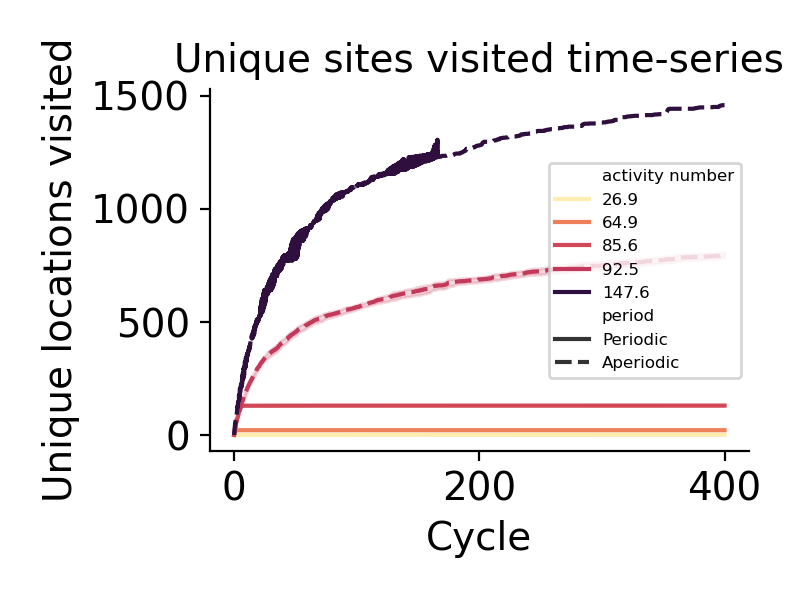

In [16]:
parameter = 'activity number'
save = False

title = 'Unique sites visited time-series'
plt.figure(figsize=(4,3))

sns.lineplot(data = df_ensemble, x = 'Cycle', 
             y = 'Unique locations visited', hue = parameter, style = 'period', ci = 95, 
             palette = cmocean.cm.matter, legend = 'full')

plt.title(title)
plt.xlabel('Cycle')
# plt.yscale('log')
plt.legend(loc='best', prop={'size':6})
sns.despine(right=True, top=True)

plt.tight_layout()

if save:
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

plt.show()

## Define functions for fitting the unique locs visited time-series data

In [75]:
import wlsice.python.wlsice as wlsice
import scipy.optimize as optimize

def f(t, N_max, Tau):
    """ Michelis-Mentin type function
    
        y = t*N_max/(t + Tau)
        
        
    """
  
    return N_max*t / (t + Tau)

def df(t, params):
    """Gradient of Michelis-Mentin type function
    gradient(a*exp(b*t)) = [exp(b*t), a*t*exp(b*t)]
    
    
    """
    N_max = params[0]
    Tau = params[1]
    
    df_array = np.zeros((len(params), len(t)))
    
    df_array[0] = t/(t + Tau)
    df_array[1] = -N_max*t/(t + Tau)**2
    
    return df_array


def d2f(t, params):
    """Hessian of linear function
    """
    N_max = params[0]
    Tau = params[1]
    
    d2f_matrix = np.zeros((len(params), len(params), len(t)))
    
    d2f_matrix[0,0] = 0
    d2f_matrix[0,1] = -t/(t + Tau)**2
    d2f_matrix[1,0] = d2f_matrix[0,1]
    d2f_matrix[1,1] = 2*N_max*t/(t + Tau)**3
        
    return d2f_matrix


In [76]:
result = df_ensemble.groupby(['activity number', 'Cycle', 'period'], as_index=False).agg({'Max locs percent':['mean', 'std']})

print(result)



     activity number       Cycle     period Max locs percent          
                                                        mean       std
0               26.9    0.000000   Periodic         0.023596  0.000000
1               26.9    0.500501   Periodic         0.049552  0.020661
2               26.9    1.001001   Periodic         0.058990  0.031949
3               26.9    1.501502   Periodic         0.063709  0.029534
4               26.9    2.002002   Periodic         0.070788  0.029429
...              ...         ...        ...              ...       ...
4995           147.6  497.997998  Aperiodic        36.385087       NaN
4996           147.6  498.498498  Aperiodic        36.385087       NaN
4997           147.6  498.998999  Aperiodic        36.385087       NaN
4998           147.6  499.499499  Aperiodic        36.385087       NaN
4999           147.6  500.000000  Aperiodic        36.385087       NaN

[5000 rows x 5 columns]


<IPython.core.display.Javascript object>


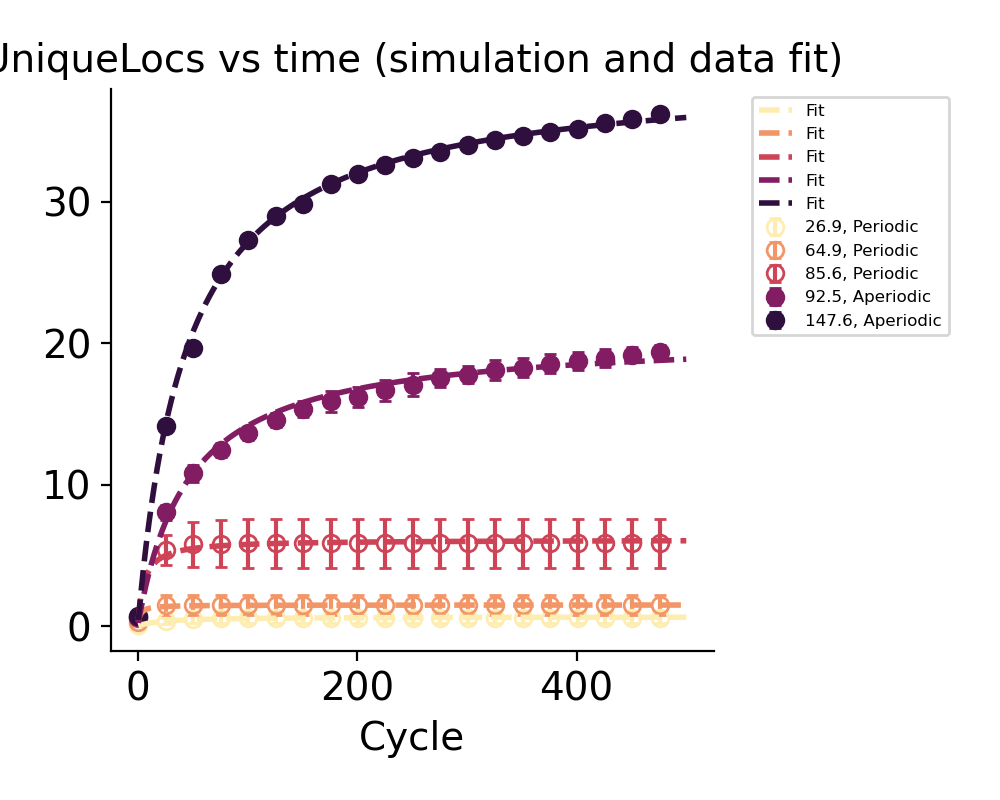

Periodic
Periodic
Periodic
Aperiodic
Aperiodic


/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [149]:
# Load the unique location time-series data for each sim parameter and perform the fit, and store the result
save = True

title = 'UniqueLocs vs time (simulation and data fit)'

categories = ['Periodic', 'Aperiodic']
markers = {'Periodic':'o', 'Aperiodic':'o'}

# cmap = plt.cm.get_cmap('Set2_r', 255)

cmap = cmocean.cm.matter
linear_array = np.linspace(0,1,len(parameter_values))
colors={}
for ii, cat in enumerate(parameter_values):
    
    colors[cat]=cmap(linear_array[ii])
    
    

df_unique_locs_fit = pd.DataFrame({})

parameter = 'activity number'

parameter_values = np.unique(df_ensemble['activity number'])

plt.figure(figsize = (5,4))
    
for value in parameter_values:
    
    df_chunk = result.loc[result[parameter]==value]
    
    # Calculate the mean and std of the unique locs time-series data
    
    unique_locs_means = np.array(df_chunk['Max locs percent']['mean'][1:])
    unique_locs_std = np.array(df_chunk['Max locs percent']['std'][1:])
    
    cycles = np.array(df_chunk['Cycle'][1:])  
    
    period = np.array(df_chunk['period'])[0]
    
    print(period)
    
    if np.any(np.isnan(unique_locs_std)) or np.any(unique_locs_std==0):
        p_opt, p_cov = optimize.curve_fit(f, cycles, unique_locs_means,
                       bounds = [(0, 0), (np.inf, np.inf)])
    else:
        p_opt, p_cov = optimize.curve_fit(f, cycles, unique_locs_means, sigma = unique_locs_std,
                   bounds = [(0, 0), (np.inf, np.inf)])
        
    perr = np.sqrt(np.diag(p_cov)) # Calculate error in the fit
    
    data_fit = np.array([f(cycle, p_opt[0], p_opt[1]) for cycle in cycles])

    if period == 'Periodic':
        plt.errorbar(cycles[::50], unique_locs_means[::50], yerr = unique_locs_std[::50], 
                     marker = markers[period] , label = '{}, {}'.format(value, period), zorder = 0, linestyle = '', 
                     color = colors[value], mfc = 'none', capsize = 2)
    else:
        plt.errorbar(cycles[::50], unique_locs_means[::50], yerr = unique_locs_std[::50], 
                     marker = markers[period] , label = '{}, {}'.format(value, period), zorder = 0, linestyle = '', 
                     color = colors[value], capsize = 2)
        
    plt.plot(cycles, data_fit, linestyle = '--', linewidth = 2, color = colors[value], label ='Fit', zorder = 1)

    
    # Store the Optimal params and the uncertainty in the fit as a Dataframe
    
    df_unique_locs_fit = df_unique_locs_fit.append(pd.DataFrame({parameter:[value], 
                         'Saturation value fit':[p_opt[0]], 'Saturation value sigma':[perr[0]], 
                            'Saturation time fit':[p_opt[1]], 'Saturation time sigma':[perr[1]]}))
    
    
    
plt.xlabel('Cycle')
# plt.yscale('log')
# plt.legend(loc='best', prop={'size':6})
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', prop={'size':6})

sns.despine(right=True, top=True)

plt.title(title)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)


In [58]:
df_unique_locs_fit

,activity number,Saturation value fit,Saturation value sigma,Saturation time fit,Saturation time sigma
0,26.9,0.656133,0.001951,22.907193,0.289780
0,30.4,0.740870,0.001595,12.180929,0.133527
0,33.8,0.810148,0.001437,6.358743,0.073280
0,37.3,0.726654,0.001126,4.554872,0.056326
0,40.7,0.839208,0.001386,3.981866,0.044172
0,44.2,1.099807,0.001595,3.934547,0.048739
0,47.6,0.796287,0.000855,2.693741,0.026708
0,51.1,1.453997,0.002172,3.339488,0.027271
0,54.5,1.019072,0.000885,1.971152,0.012613
0,58.0,1.315983,0.000704,2.210203,0.012178


In [59]:
# Save the data to file

df_unique_locs_fit.to_csv(os.path.join(publication_figures, 'UniqueLocs_time_series_fit.csv'))